In [20]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchviz import make_dot
import os
from PIL import Image
from tqdm import tqdm
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
import time
import pickle
from albumentations.pytorch import ToTensorV2
from helpers import *

In [2]:
CONFIG = {
    'DATASET_DIR': './dataset/carvana',
    'NUM_WORKERS': os.cpu_count(),
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    'N_EPOCHS': 1000,
    'BATCH_SIZE': 32,
    'IM_HEIGHT': 160, # 1280 originally
    'IM_WIDTH': 240, # 1918 originally
    'PIN_MEMORY': True,
       
}

# Data Visualization

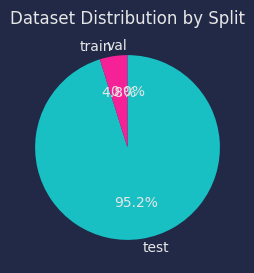

,Split,Number of Images
0,test,100064
1,train,5040
2,val,48


In [3]:
calc_dataset_statistics(CONFIG['DATASET_DIR'])

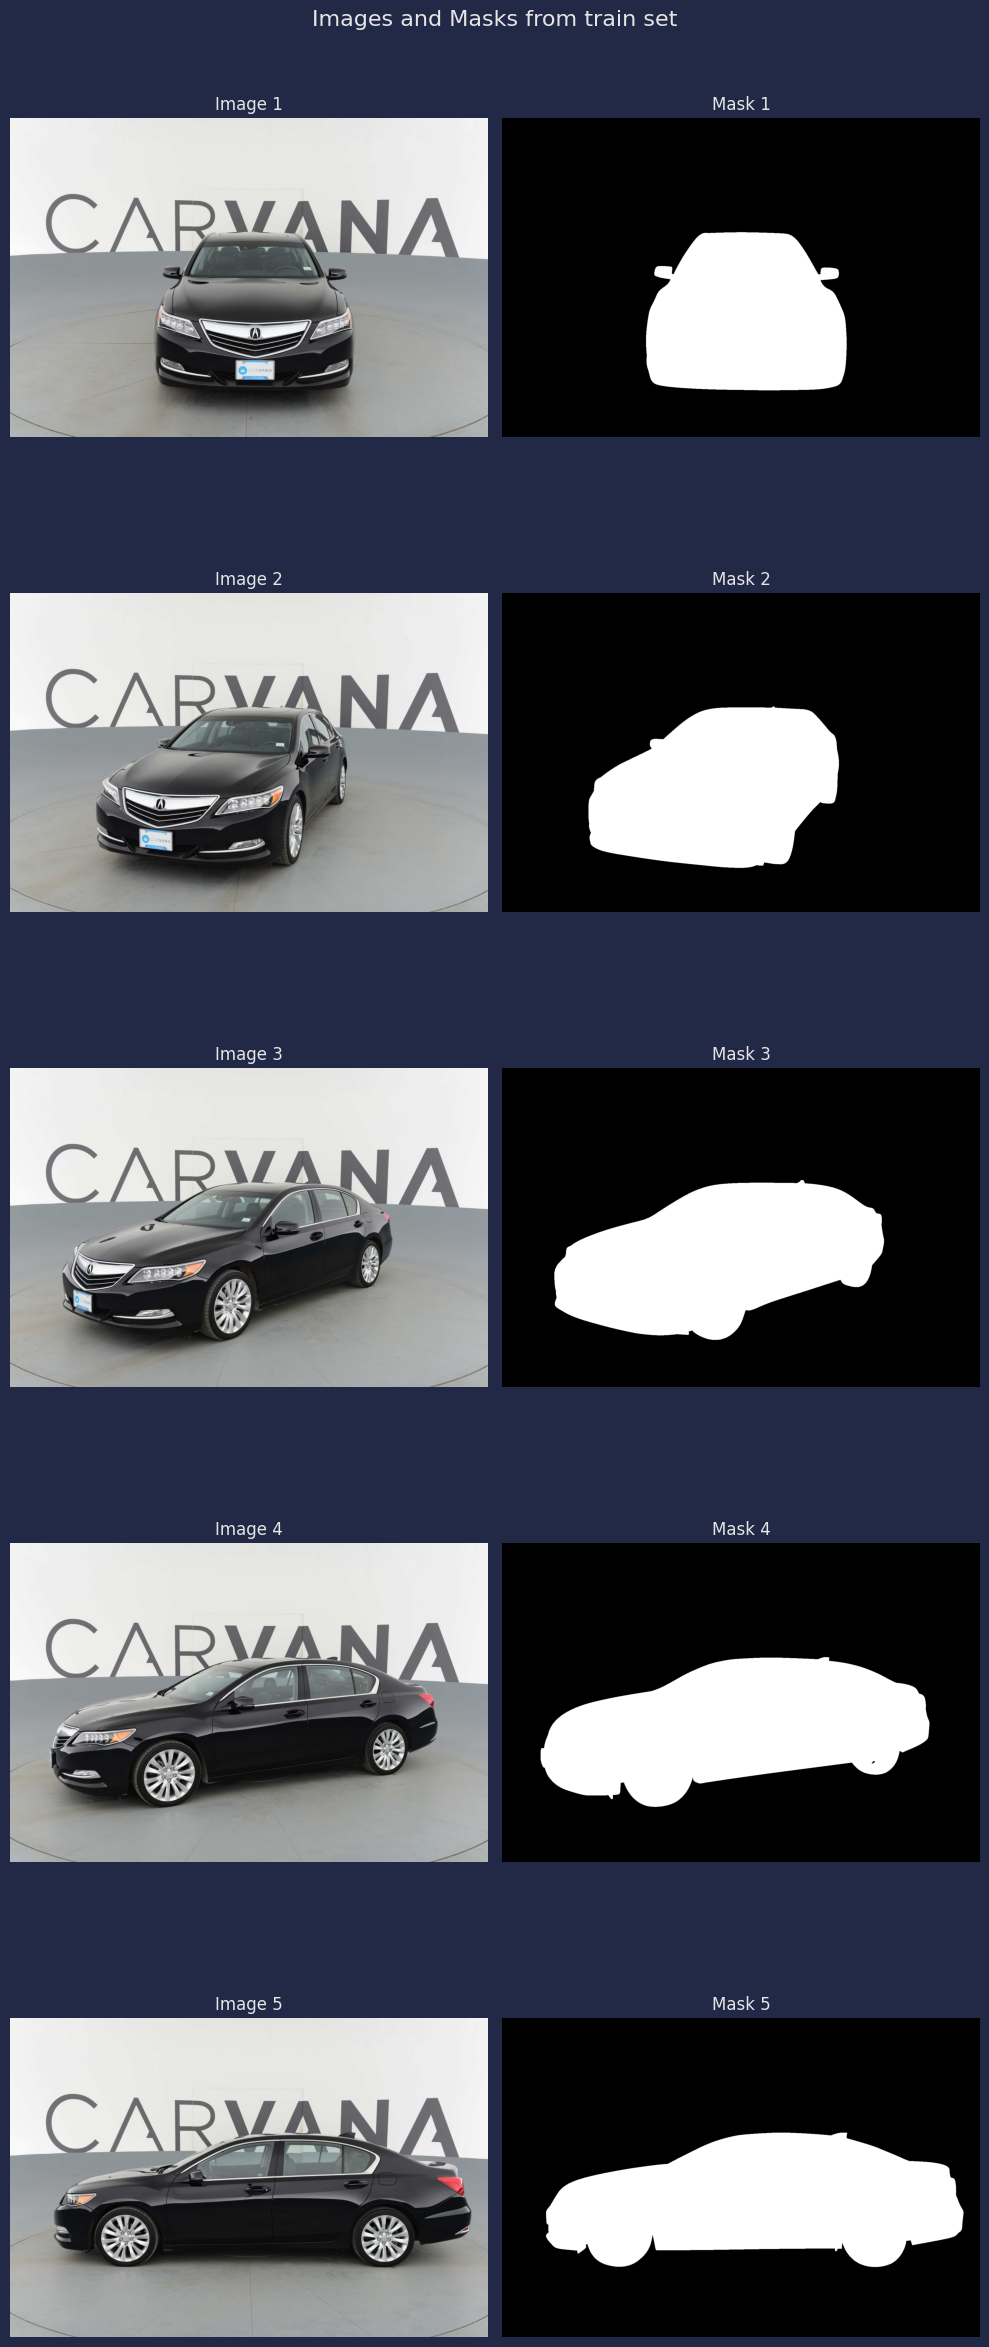

In [4]:
plot_seg_data(CONFIG['DATASET_DIR'], 'train', 5)

# Modeling

## Unet from scratch

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
                                        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
                                        nn.BatchNorm2d(out_channels),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
                                        nn.BatchNorm2d(out_channels),
                                        nn.ReLU(inplace=True),
                                        
        )
        
        
    def forward(self, x):
        return self.conv(x)
    
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):  # out_channels here is the number of classes to segment
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            # Append ConvTranspose2d and DoubleConv separately
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))  # Upsampling layer
            self.ups.append(DoubleConv(feature * 2, feature))  # Double convolution

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)  # Bottleneck
        self.finalconv = nn.Conv2d(features[0], out_channels, kernel_size=1)  # Final convolution

    def forward(self, x):
        skip_conns = []

        # Downward part
        for down in self.downs:
            x = down(x)
            skip_conns.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_conns = skip_conns[::-1]  # Reverse the skip connections

        # Upward part
        for idx in range(0, len(self.ups), 2):  # Step of 2 because of upsampling and DoubleConv
            x = self.ups[idx](x)  # Upsampling
            curr_skip = skip_conns[idx // 2]
            if x.shape != curr_skip.shape:
                x = TF.resize(x, size=curr_skip.shape[2:])
            concat_skip = torch.cat((curr_skip, x), dim=1)  # Concatenate along the channel dimension
            x = self.ups[idx + 1](concat_skip)  # Double convolution

        return self.finalconv(x)

In [6]:
def test():
    x = torch.randn((3,1, 160, 160))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(x.shape)
    print(preds.shape)
    assert x.shape == preds.shape
    
test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [7]:
# Dataset implementation to load dataset
class SegDataset(Dataset):
    def __init__(self, im_dir, mask_dir, transform = None):
        super().__init__()
        self.im_dir = im_dir
        self.mask_dir = mask_dir
        self.transforms = transform
        
        self.images = os.listdir(self.im_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        im_path = os.path.join(self.im_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", "_mask.gif"))
        im = np.array(Image.open(im_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype= np.float32) # Converting to grayscale (L)
        mask[mask==255.0] = 1.0 # We convert the bright spots to 1
        if self.transforms:
            augmentations = self.transforms(image=im, mask= mask)
            im = augmentations['image']
            mask = augmentations['mask']

        return im, mask

In [8]:
# Augmentations
train_transforms = A.Compose([
    A.Resize(CONFIG['IM_HEIGHT'], CONFIG['IM_WIDTH']),
    A.Rotate(limit=35, p=0.6),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.6),
    A.Normalize(
        mean= [0.0, 0.0, 0.0],
        std = [1.0, 1.0, 1.0],
        max_pixel_value = 255.0
    ),
    ToTensorV2()
])
val_test_transforms = A.Compose([
    A.Resize(CONFIG['IM_HEIGHT'], CONFIG['IM_WIDTH']),
    A.Normalize(
        mean= [0.0, 0.0, 0.0],
        std = [1.0, 1.0, 1.0],
        max_pixel_value = 255.0
    ),
    ToTensorV2()
])

In [9]:
# Datasets and laoders
train_dataset = SegDataset(os.path.join(CONFIG['DATASET_DIR'], 'train'), os.path.join(CONFIG['DATASET_DIR'], 'train_masks'), transform=train_transforms)
val_dataset = SegDataset(os.path.join(CONFIG['DATASET_DIR'], 'val'), os.path.join(CONFIG['DATASET_DIR'], 'val_masks'), transform=val_test_transforms)
train_loader = DataLoader(train_dataset, CONFIG['BATCH_SIZE'], shuffle=True, num_workers=CONFIG['NUM_WORKERS'], pin_memory=CONFIG['PIN_MEMORY'])
val_loader = DataLoader(val_dataset, CONFIG['BATCH_SIZE'], shuffle=False, num_workers=CONFIG['NUM_WORKERS'], pin_memory=CONFIG['PIN_MEMORY'])
dataloaders = {'TRAIN': train_loader, 'VAL': val_loader}
dataset_sizes = {
    'TRAIN': len(train_loader.dataset),
    'VAL': len(val_loader.dataset),
    }
print(dataset_sizes)

{'TRAIN': 5040, 'VAL': 48}


In [10]:
for i, j in train_loader:
    print(i.shape, j.shape)
    break

torch.Size([32, 3, 160, 240]) torch.Size([32, 160, 240])


In [11]:
# Evaluation metrics
# Dice coefficient implementation
def dice_score(preds, targets, threshold=0.5, smooth=1e-6):
    preds = (preds > threshold).float()  # Threshold predictions at 0.5
    intersection = (preds * targets).sum(dim=[2, 3])  # Sum over H and W dimensions
    union = preds.sum(dim=[2, 3]) + targets.sum(dim=[2, 3])
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice  # Return batch-wise Dice score

def pixel_accuracy(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()  # Threshold predictions at 0.5
    correct = (preds == targets).float().sum(dim=[2, 3])  # Correct pixel predictions
    total_pixels = preds.size(2) * preds.size(3)  # Total pixels per image
    return correct / total_pixels  # Return batch-wise pixel accuracy

In [12]:
# Loss metric
def dice_loss(preds, targets, epsilon=1e-6):
    """
    Compute the Dice Loss.

    Args:
        preds (torch.Tensor): The predicted outputs (logits or probabilities).
        targets (torch.Tensor): The ground truth labels (same shape as preds).
        epsilon (float): A small value to avoid division by zero.

    Returns:
        float: The Dice loss.
    """
    # Flatten the tensors
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    # Calculate the intersection and union
    intersection = (preds * targets).sum()
    loss = 1 - (2. * intersection + epsilon) / (preds.sum() + targets.sum() + epsilon)

    return loss

In [13]:
# Hyperparameters
lr = 1e-4
unet_model = UNET(3, 1).to(CONFIG['DEVICE'])
optimizer = torch.optim.Adam(unet_model.parameters(), lr= lr)
# criterion = nn.BCEWithLogitsLoss()
criterion = dice_loss

# Training

In [18]:
def save_metrics(metrics, save_path='metrics.pkl'):
    """
    Save metrics to a file.

    Args:
    - metrics: Dictionary containing metrics to save
    - save_path: Path to save the metrics file
    """
    with open(save_path, 'wb') as f:
        pickle.dump(metrics, f)

## Unet from scratch

In [14]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler=None,
                num_epochs=CONFIG['N_EPOCHS'], device=CONFIG['DEVICE'], patience=35):
    since = time.time()
    best_model_wts = deepcopy(model.state_dict())
    best_loss = float('inf')
    no_improve = 0
    scaler = torch.amp.GradScaler(enabled=True)
    model = model.float().to(device=device)

    metrics = {'train_loss': [], 'val_loss': [],
               'train_dice': [], 'val_dice': [],
               'train_pixel_acc': [], 'val_pixel_acc': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['TRAIN', 'VAL']:
            if phase == 'TRAIN':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_dice = 0.0
            running_pixel_acc = 0.0

            for inputs, labels in tqdm(dataloaders[phase], desc=phase.capitalize()):
                inputs = inputs.to(device=device)
                labels = labels.to(device=device).float().unsqueeze(1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'TRAIN'):
                    with torch.amp.autocast(device_type=device, dtype=torch.float16):
                        outputs = model(inputs)
                        preds = torch.sigmoid(outputs)
                        loss = criterion(preds, labels)

                        if phase == 'TRAIN':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                            if scheduler:
                                scheduler.step()

                running_loss += loss.item() * inputs.size(0)

                # Batch-wise metrics calculation
                batch_dice = dice_score(preds, labels).mean().item()  # Get the mean Dice for this batch
                batch_pixel_acc = pixel_accuracy(preds, labels).mean().item()  # Pixel-wise accuracy for this batch

                running_dice += batch_dice * inputs.size(0)  # Accumulate Dice score
                running_pixel_acc += batch_pixel_acc * inputs.size(0)  # Accumulate pixel accuracy

            # Epoch metrics (average over all batches)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_dice = running_dice / dataset_sizes[phase]
            epoch_pixel_acc = running_pixel_acc / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Dice: {epoch_dice:.4f} Pixel Acc: {epoch_pixel_acc:.4f}')

            # Log metrics
            if phase == 'TRAIN':
                metrics['train_loss'].append(epoch_loss)
                metrics['train_dice'].append(epoch_dice)
                metrics['train_pixel_acc'].append(epoch_pixel_acc)
            else:
                metrics['val_loss'].append(epoch_loss)
                metrics['val_dice'].append(epoch_dice)
                metrics['val_pixel_acc'].append(epoch_pixel_acc)

            if phase == 'VAL' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = deepcopy(model.state_dict())
                no_improve = 0
            else:
                no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            break

    time_elapsed = time.time() - since
    print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Loss: {best_loss:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics

In [15]:
unet_model, unet_metrics = train_model(unet_model, dataloaders, dataset_sizes, criterion, optimizer, scheduler=None,
                num_epochs=CONFIG['N_EPOCHS'], device=CONFIG['DEVICE'], patience=15)

Epoch 1/1000
----------


Train:   0%|          | 0/158 [00:00<?, ?it/s]

Train: 100%|██████████| 158/158 [00:30<00:00,  5.19it/s]


TRAIN Loss: 0.3061 Dice: 0.9093 Pixel Acc: 0.9610


Val: 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


VAL Loss: 0.2372 Dice: 0.9670 Pixel Acc: 0.9870
Epoch 2/1000
----------


Train: 100%|██████████| 158/158 [00:29<00:00,  5.42it/s]


TRAIN Loss: 0.1890 Dice: 0.9708 Pixel Acc: 0.9875


Val: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


VAL Loss: 0.1647 Dice: 0.9802 Pixel Acc: 0.9924
Epoch 3/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.54it/s]


TRAIN Loss: 0.1343 Dice: 0.9779 Pixel Acc: 0.9906


Val: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


VAL Loss: 0.1188 Dice: 0.9849 Pixel Acc: 0.9943
Epoch 4/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.60it/s]


TRAIN Loss: 0.1009 Dice: 0.9785 Pixel Acc: 0.9908


Val: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


VAL Loss: 0.0910 Dice: 0.9806 Pixel Acc: 0.9925
Epoch 5/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.60it/s]


TRAIN Loss: 0.0751 Dice: 0.9826 Pixel Acc: 0.9926


Val: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


VAL Loss: 0.0694 Dice: 0.9850 Pixel Acc: 0.9943
Epoch 6/1000
----------


Train: 100%|██████████| 158/158 [00:27<00:00,  5.64it/s]


TRAIN Loss: 0.0601 Dice: 0.9828 Pixel Acc: 0.9927


Val: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


VAL Loss: 0.0606 Dice: 0.9809 Pixel Acc: 0.9927
Epoch 7/1000
----------


Train: 100%|██████████| 158/158 [00:29<00:00,  5.41it/s]


TRAIN Loss: 0.0498 Dice: 0.9825 Pixel Acc: 0.9926


Val: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


VAL Loss: 0.0417 Dice: 0.9882 Pixel Acc: 0.9956
Epoch 8/1000
----------


Train: 100%|██████████| 158/158 [00:29<00:00,  5.44it/s]


TRAIN Loss: 0.0395 Dice: 0.9852 Pixel Acc: 0.9938


Val: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


VAL Loss: 0.0362 Dice: 0.9869 Pixel Acc: 0.9950
Epoch 9/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.50it/s]


TRAIN Loss: 0.0348 Dice: 0.9850 Pixel Acc: 0.9936


Val: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


VAL Loss: 0.0310 Dice: 0.9884 Pixel Acc: 0.9956
Epoch 10/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.56it/s]


TRAIN Loss: 0.0298 Dice: 0.9863 Pixel Acc: 0.9942


Val: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


VAL Loss: 0.0272 Dice: 0.9884 Pixel Acc: 0.9956
Epoch 11/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.61it/s]


TRAIN Loss: 0.0266 Dice: 0.9867 Pixel Acc: 0.9944


Val: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


VAL Loss: 0.0238 Dice: 0.9893 Pixel Acc: 0.9959
Epoch 12/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.63it/s]


TRAIN Loss: 0.0239 Dice: 0.9872 Pixel Acc: 0.9946


Val: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


VAL Loss: 0.0208 Dice: 0.9899 Pixel Acc: 0.9961
Epoch 13/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.61it/s]


TRAIN Loss: 0.0221 Dice: 0.9873 Pixel Acc: 0.9946


Val: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


VAL Loss: 0.0253 Dice: 0.9851 Pixel Acc: 0.9943
Epoch 14/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.49it/s]


TRAIN Loss: 0.0215 Dice: 0.9864 Pixel Acc: 0.9943


Val: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


VAL Loss: 0.0212 Dice: 0.9874 Pixel Acc: 0.9952
Epoch 15/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.52it/s]


TRAIN Loss: 0.0195 Dice: 0.9873 Pixel Acc: 0.9947


Val: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


VAL Loss: 0.0172 Dice: 0.9898 Pixel Acc: 0.9962
Epoch 16/1000
----------


Train: 100%|██████████| 158/158 [00:29<00:00,  5.43it/s]


TRAIN Loss: 0.0178 Dice: 0.9881 Pixel Acc: 0.9950


Val: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


VAL Loss: 0.0155 Dice: 0.9905 Pixel Acc: 0.9964
Epoch 17/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.58it/s]


TRAIN Loss: 0.0166 Dice: 0.9885 Pixel Acc: 0.9951


Val: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


VAL Loss: 0.0145 Dice: 0.9908 Pixel Acc: 0.9965
Epoch 18/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.49it/s]


TRAIN Loss: 0.0159 Dice: 0.9885 Pixel Acc: 0.9952


Val: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


VAL Loss: 0.0144 Dice: 0.9903 Pixel Acc: 0.9963
Epoch 19/1000
----------


Train: 100%|██████████| 158/158 [00:29<00:00,  5.38it/s]


TRAIN Loss: 0.0153 Dice: 0.9887 Pixel Acc: 0.9952


Val: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


VAL Loss: 0.0133 Dice: 0.9907 Pixel Acc: 0.9965
Epoch 20/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.46it/s]


TRAIN Loss: 0.0146 Dice: 0.9888 Pixel Acc: 0.9953


Val: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


VAL Loss: 0.0130 Dice: 0.9906 Pixel Acc: 0.9965
Epoch 21/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.58it/s]


TRAIN Loss: 0.0140 Dice: 0.9890 Pixel Acc: 0.9954


Val: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


VAL Loss: 0.0124 Dice: 0.9908 Pixel Acc: 0.9965
Epoch 22/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.60it/s]


TRAIN Loss: 0.0137 Dice: 0.9890 Pixel Acc: 0.9954


Val: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


VAL Loss: 0.0117 Dice: 0.9911 Pixel Acc: 0.9966
Epoch 23/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.58it/s]


TRAIN Loss: 0.0133 Dice: 0.9891 Pixel Acc: 0.9954


Val: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


VAL Loss: 0.0115 Dice: 0.9908 Pixel Acc: 0.9965
Epoch 24/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.59it/s]


TRAIN Loss: 0.0139 Dice: 0.9883 Pixel Acc: 0.9950


Val: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


VAL Loss: 0.0113 Dice: 0.9909 Pixel Acc: 0.9965
Epoch 25/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.58it/s]


TRAIN Loss: 0.0127 Dice: 0.9892 Pixel Acc: 0.9954


Val: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


VAL Loss: 0.0109 Dice: 0.9909 Pixel Acc: 0.9966
Epoch 26/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.56it/s]


TRAIN Loss: 0.0123 Dice: 0.9894 Pixel Acc: 0.9955


Val: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


VAL Loss: 0.0105 Dice: 0.9912 Pixel Acc: 0.9967
Epoch 27/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.47it/s]


TRAIN Loss: 0.0122 Dice: 0.9894 Pixel Acc: 0.9955


Val: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


VAL Loss: 0.0103 Dice: 0.9912 Pixel Acc: 0.9967
Epoch 28/1000
----------


Train: 100%|██████████| 158/158 [00:27<00:00,  5.69it/s]


TRAIN Loss: 0.0120 Dice: 0.9894 Pixel Acc: 0.9955


Val: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


VAL Loss: 0.0104 Dice: 0.9909 Pixel Acc: 0.9966
Epoch 29/1000
----------


Train: 100%|██████████| 158/158 [00:27<00:00,  5.71it/s]


TRAIN Loss: 0.0114 Dice: 0.9898 Pixel Acc: 0.9957


Val: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


VAL Loss: 0.0097 Dice: 0.9915 Pixel Acc: 0.9968
Epoch 30/1000
----------


Train: 100%|██████████| 158/158 [00:27<00:00,  5.73it/s]


TRAIN Loss: 0.0121 Dice: 0.9891 Pixel Acc: 0.9954


Val: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


VAL Loss: 0.0097 Dice: 0.9912 Pixel Acc: 0.9967
Epoch 31/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.53it/s]


TRAIN Loss: 0.0113 Dice: 0.9897 Pixel Acc: 0.9957


Val: 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


VAL Loss: 0.0093 Dice: 0.9918 Pixel Acc: 0.9969
Epoch 32/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.52it/s]


TRAIN Loss: 0.0109 Dice: 0.9900 Pixel Acc: 0.9958


Val: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


VAL Loss: 0.0092 Dice: 0.9917 Pixel Acc: 0.9969
Epoch 33/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.60it/s]


TRAIN Loss: 0.0107 Dice: 0.9901 Pixel Acc: 0.9958


Val: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


VAL Loss: 0.0087 Dice: 0.9921 Pixel Acc: 0.9970
Epoch 34/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.47it/s]


TRAIN Loss: 0.0106 Dice: 0.9902 Pixel Acc: 0.9958


Val: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


VAL Loss: 0.0093 Dice: 0.9915 Pixel Acc: 0.9967
Epoch 35/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.58it/s]


TRAIN Loss: 0.0105 Dice: 0.9902 Pixel Acc: 0.9959


Val: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


VAL Loss: 0.0088 Dice: 0.9917 Pixel Acc: 0.9969
Epoch 36/1000
----------


Train: 100%|██████████| 158/158 [00:29<00:00,  5.42it/s]


TRAIN Loss: 0.0104 Dice: 0.9902 Pixel Acc: 0.9959


Val: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


VAL Loss: 0.0090 Dice: 0.9915 Pixel Acc: 0.9968
Epoch 37/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.48it/s]


TRAIN Loss: 0.0102 Dice: 0.9904 Pixel Acc: 0.9959


Val: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


VAL Loss: 0.0086 Dice: 0.9919 Pixel Acc: 0.9970
Epoch 38/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.45it/s]


TRAIN Loss: 0.0101 Dice: 0.9904 Pixel Acc: 0.9960


Val: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


VAL Loss: 0.0080 Dice: 0.9925 Pixel Acc: 0.9971
Epoch 39/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.52it/s]


TRAIN Loss: 0.0100 Dice: 0.9904 Pixel Acc: 0.9960


Val: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


VAL Loss: 0.0080 Dice: 0.9923 Pixel Acc: 0.9971
Epoch 40/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.49it/s]


TRAIN Loss: 0.0099 Dice: 0.9905 Pixel Acc: 0.9960


Val: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


VAL Loss: 0.0079 Dice: 0.9926 Pixel Acc: 0.9972
Epoch 41/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.60it/s]


TRAIN Loss: 0.0098 Dice: 0.9906 Pixel Acc: 0.9960


Val: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


VAL Loss: 0.0081 Dice: 0.9922 Pixel Acc: 0.9970
Epoch 42/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.63it/s]


TRAIN Loss: 0.0098 Dice: 0.9906 Pixel Acc: 0.9960


Val: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


VAL Loss: 0.0084 Dice: 0.9918 Pixel Acc: 0.9969
Epoch 43/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.54it/s]


TRAIN Loss: 0.0097 Dice: 0.9907 Pixel Acc: 0.9961


Val: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


VAL Loss: 0.0077 Dice: 0.9925 Pixel Acc: 0.9972
Epoch 44/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.47it/s]


TRAIN Loss: 0.0096 Dice: 0.9907 Pixel Acc: 0.9961


Val: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


VAL Loss: 0.0078 Dice: 0.9924 Pixel Acc: 0.9971
Epoch 45/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.53it/s]


TRAIN Loss: 0.0120 Dice: 0.9884 Pixel Acc: 0.9951


Val: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


VAL Loss: 0.0100 Dice: 0.9902 Pixel Acc: 0.9963
Epoch 46/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.56it/s]


TRAIN Loss: 0.0114 Dice: 0.9889 Pixel Acc: 0.9953


Val: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


VAL Loss: 0.0081 Dice: 0.9921 Pixel Acc: 0.9970
Epoch 47/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.58it/s]


TRAIN Loss: 0.0099 Dice: 0.9904 Pixel Acc: 0.9959


Val: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


VAL Loss: 0.0078 Dice: 0.9924 Pixel Acc: 0.9971
Epoch 48/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.51it/s]


TRAIN Loss: 0.0096 Dice: 0.9906 Pixel Acc: 0.9960


Val: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


VAL Loss: 0.0075 Dice: 0.9927 Pixel Acc: 0.9972
Epoch 49/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.57it/s]


TRAIN Loss: 0.0095 Dice: 0.9907 Pixel Acc: 0.9961


Val: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


VAL Loss: 0.0079 Dice: 0.9922 Pixel Acc: 0.9970
Epoch 50/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.53it/s]


TRAIN Loss: 0.0093 Dice: 0.9909 Pixel Acc: 0.9961


Val: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


VAL Loss: 0.0079 Dice: 0.9922 Pixel Acc: 0.9971
Epoch 51/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.56it/s]


TRAIN Loss: 0.0092 Dice: 0.9909 Pixel Acc: 0.9962


Val: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


VAL Loss: 0.0074 Dice: 0.9926 Pixel Acc: 0.9972
Epoch 52/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.53it/s]


TRAIN Loss: 0.0092 Dice: 0.9910 Pixel Acc: 0.9962


Val: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


VAL Loss: 0.0075 Dice: 0.9926 Pixel Acc: 0.9972
Epoch 53/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.53it/s]


TRAIN Loss: 0.0091 Dice: 0.9910 Pixel Acc: 0.9962


Val: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


VAL Loss: 0.0075 Dice: 0.9926 Pixel Acc: 0.9972
Epoch 54/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.53it/s]


TRAIN Loss: 0.0091 Dice: 0.9910 Pixel Acc: 0.9962


Val: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


VAL Loss: 0.0072 Dice: 0.9928 Pixel Acc: 0.9973
Epoch 55/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.53it/s]


TRAIN Loss: 0.0090 Dice: 0.9911 Pixel Acc: 0.9962


Val: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


VAL Loss: 0.0073 Dice: 0.9928 Pixel Acc: 0.9973
Epoch 56/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.50it/s]


TRAIN Loss: 0.0091 Dice: 0.9910 Pixel Acc: 0.9962


Val: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


VAL Loss: 0.0070 Dice: 0.9930 Pixel Acc: 0.9974
Epoch 57/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.61it/s]


TRAIN Loss: 0.0090 Dice: 0.9911 Pixel Acc: 0.9962


Val: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


VAL Loss: 0.0075 Dice: 0.9926 Pixel Acc: 0.9972
Epoch 58/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.51it/s]


TRAIN Loss: 0.0090 Dice: 0.9911 Pixel Acc: 0.9962


Val: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


VAL Loss: 0.0071 Dice: 0.9929 Pixel Acc: 0.9973
Epoch 59/1000
----------


Train: 100%|██████████| 158/158 [00:29<00:00,  5.41it/s]


TRAIN Loss: 0.0089 Dice: 0.9911 Pixel Acc: 0.9963


Val: 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


VAL Loss: 0.0073 Dice: 0.9927 Pixel Acc: 0.9972
Epoch 60/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.55it/s]


TRAIN Loss: 0.0090 Dice: 0.9910 Pixel Acc: 0.9962


Val: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


VAL Loss: 0.0075 Dice: 0.9925 Pixel Acc: 0.9972
Epoch 61/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.48it/s]


TRAIN Loss: 0.0090 Dice: 0.9911 Pixel Acc: 0.9962


Val: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


VAL Loss: 0.0076 Dice: 0.9924 Pixel Acc: 0.9971
Epoch 62/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.54it/s]


TRAIN Loss: 0.0089 Dice: 0.9911 Pixel Acc: 0.9963


Val: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


VAL Loss: 0.0070 Dice: 0.9930 Pixel Acc: 0.9974
Epoch 63/1000
----------


Train: 100%|██████████| 158/158 [00:28<00:00,  5.51it/s]


TRAIN Loss: 0.0089 Dice: 0.9912 Pixel Acc: 0.9963


Val: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


VAL Loss: 0.0069 Dice: 0.9931 Pixel Acc: 0.9974
Epoch 64/1000
----------


Train: 100%|██████████| 158/158 [00:27<00:00,  5.67it/s]


TRAIN Loss: 0.0088 Dice: 0.9912 Pixel Acc: 0.9963


Val: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


VAL Loss: 0.0074 Dice: 0.9926 Pixel Acc: 0.9972
Epoch 65/1000
----------


Train: 100%|██████████| 158/158 [00:27<00:00,  5.68it/s]


TRAIN Loss: 0.0088 Dice: 0.9913 Pixel Acc: 0.9963


Val: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


VAL Loss: 0.0071 Dice: 0.9929 Pixel Acc: 0.9973
Epoch 66/1000
----------


Train: 100%|██████████| 158/158 [00:27<00:00,  5.65it/s]


TRAIN Loss: 0.0088 Dice: 0.9913 Pixel Acc: 0.9963


Val: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


VAL Loss: 0.0070 Dice: 0.9929 Pixel Acc: 0.9973
Epoch 67/1000
----------


Train: 100%|██████████| 158/158 [00:27<00:00,  5.70it/s]


TRAIN Loss: 0.0088 Dice: 0.9912 Pixel Acc: 0.9963


Val: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


VAL Loss: 0.0073 Dice: 0.9926 Pixel Acc: 0.9972
Epoch 68/1000
----------


Train: 100%|██████████| 158/158 [00:27<00:00,  5.66it/s]


TRAIN Loss: 0.0087 Dice: 0.9913 Pixel Acc: 0.9963


Val: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


VAL Loss: 0.0075 Dice: 0.9925 Pixel Acc: 0.9972
Epoch 69/1000
----------


Train: 100%|██████████| 158/158 [00:27<00:00,  5.71it/s]


TRAIN Loss: 0.0087 Dice: 0.9913 Pixel Acc: 0.9964


Val: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


VAL Loss: 0.0071 Dice: 0.9929 Pixel Acc: 0.9973
Epoch 70/1000
----------


Train: 100%|██████████| 158/158 [00:27<00:00,  5.67it/s]


TRAIN Loss: 0.0087 Dice: 0.9913 Pixel Acc: 0.9963


Val: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


VAL Loss: 0.0069 Dice: 0.9930 Pixel Acc: 0.9974
Epoch 71/1000
----------


Train: 100%|██████████| 158/158 [00:27<00:00,  5.66it/s]


TRAIN Loss: 0.0088 Dice: 0.9912 Pixel Acc: 0.9963


Val: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

VAL Loss: 0.0070 Dice: 0.9929 Pixel Acc: 0.9973
Early stopping triggered after epoch 71
Training completed in 35m 6s
Best val Loss: 0.0069


In [16]:
torch.save(unet_model, 'models/unet_model.pth')

In [21]:
save_metrics(unet_metrics, 'models/unet_metrics.pkl')

# Model Evaluation

## Unet from scratch

In [23]:
import matplotlib.pyplot as plt
import pickle

def plot_metrics(metrics=None, metrics_path=None):
    """
    Plot training and validation metrics.

    Args:
    - metrics: Dictionary containing lists of metrics for 'train' and 'val'
    - metrics_path: Path to the saved metrics file
    """
    # Load metrics from file if a path is provided
    if metrics_path is not None:
        with open(metrics_path, 'rb') as f:
            metrics = pickle.load(f)

    if metrics is None:
        raise ValueError("Either metrics or metrics_path must be provided")

    epochs = range(1, len(metrics['train_loss']) + 1)

    # Create a figure to hold the plots
    plt.figure(figsize=(18, 6))

    # Plot loss
    plt.subplot(1, 3, 1)
    if 'train_loss' in metrics and 'val_loss' in metrics:
        plt.plot(epochs, metrics['train_loss'], label='Train Loss')
        plt.plot(epochs, metrics['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

    # Plot Dice metrics
    plt.subplot(1, 3, 2)
    if 'train_dice' in metrics and 'val_dice' in metrics:
        plt.plot(epochs, metrics['train_dice'], label='Train Dice')
        plt.plot(epochs, metrics['val_dice'], label='Val Dice')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.title('Dice Score')
        plt.legend()

    # Plot Pixel Accuracy metrics
    plt.subplot(1, 3, 3)
    if 'train_pixel_acc' in metrics and 'val_pixel_acc' in metrics:
        plt.plot(epochs, metrics['train_pixel_acc'], label='Train Pixel Acc')
        plt.plot(epochs, metrics['val_pixel_acc'], label='Val Pixel Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Pixel Accuracy')
        plt.title('Pixel Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [24]:
unet_model = torch.load('models/unet_model.pth')

/tmp/ipykernel_371041/1074509513.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model = torch.load('models/unet_model.pth')


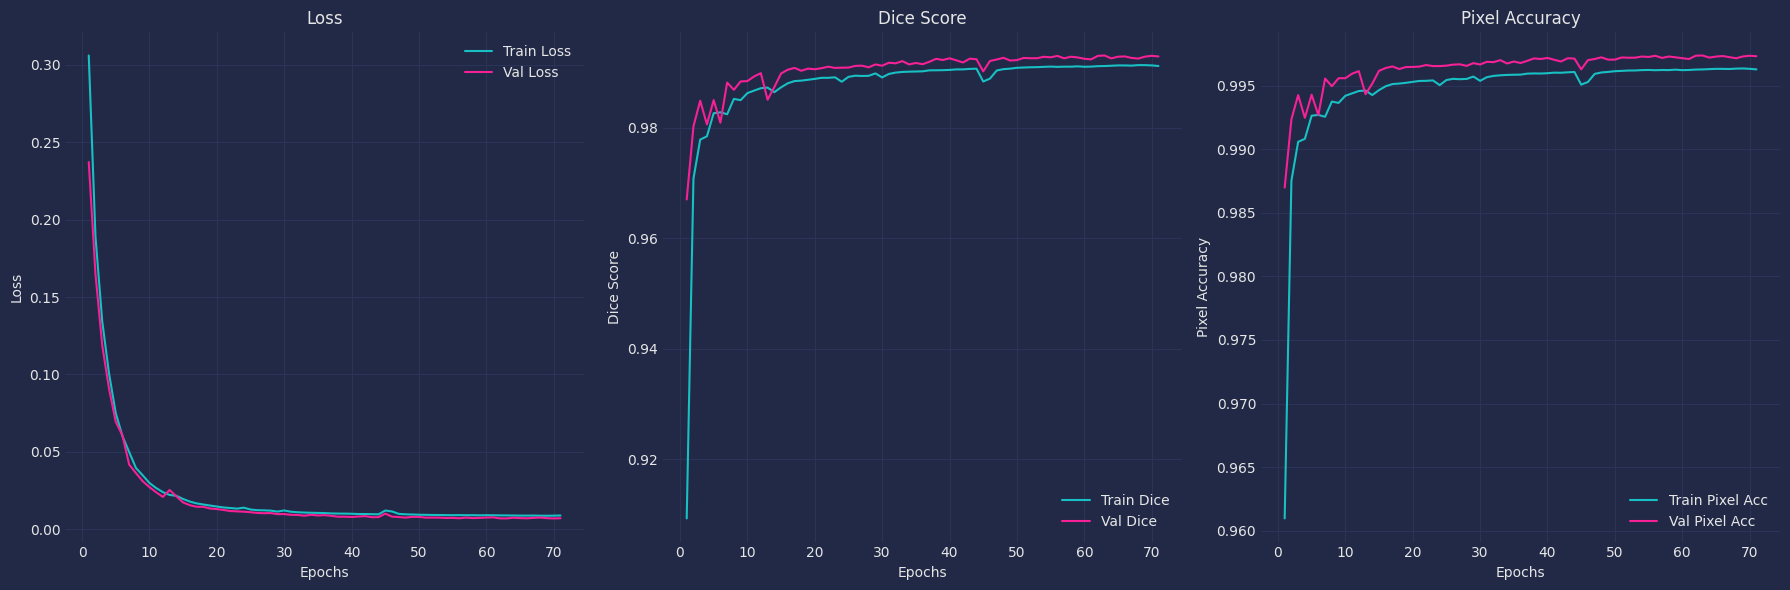

In [25]:
plot_metrics(metrics_path='models/unet_metrics.pkl')

In [51]:
# Predicting on test images
def eval_test(model, device, dataset_dir, split, transforms, num_images):
    im_split_dir = os.path.join(dataset_dir, split)
    mask_split_dir = os.path.join(dataset_dir, f"{split}_masks")
    
    if not os.path.exists(im_split_dir):
        return f"Invalid split path. Format the path as /dataset_dir/{split}"
    if not os.path.exists(mask_split_dir):
        return f"Invalid split mask path. Format the masks path as /dataset_dir/{split}_masks"
    
    image_names = sorted(os.listdir(im_split_dir))
    
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5*num_images))
    fig.suptitle(f"Images and Masks from {split} set", fontsize=16)
    
    for idx, image_name in enumerate(image_names[:num_images]):
        im_path = os.path.join(im_split_dir, image_name)
        try:
            im = Image.open(im_path)
            original_im = np.array(im)
        except Exception as e:
            print(f"Error loading image {im_path}: {e}")
            continue
        if transforms:
            augments = transforms(image = original_im)
            im = augments['image']
            im = torch.tensor(im).to(device).unsqueeze(0)

        preds = torch.sigmoid(model(im)).squeeze(0).detach().cpu().permute(1,2,0)
        mask = preds > 0.5
        axes[idx, 0].imshow(original_im)
        axes[idx, 0].set_title(f"Image {idx+1}")
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(mask, cmap='gray')
        axes[idx, 1].set_title(f"Predicted Mask {idx+1}")
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_371041/3538133062.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  im = torch.tensor(im).to(device).unsqueeze(0)


torch.Size([160, 240, 1])
torch.Size([160, 240, 1])
torch.Size([160, 240, 1])
torch.Size([160, 240, 1])
torch.Size([160, 240, 1])


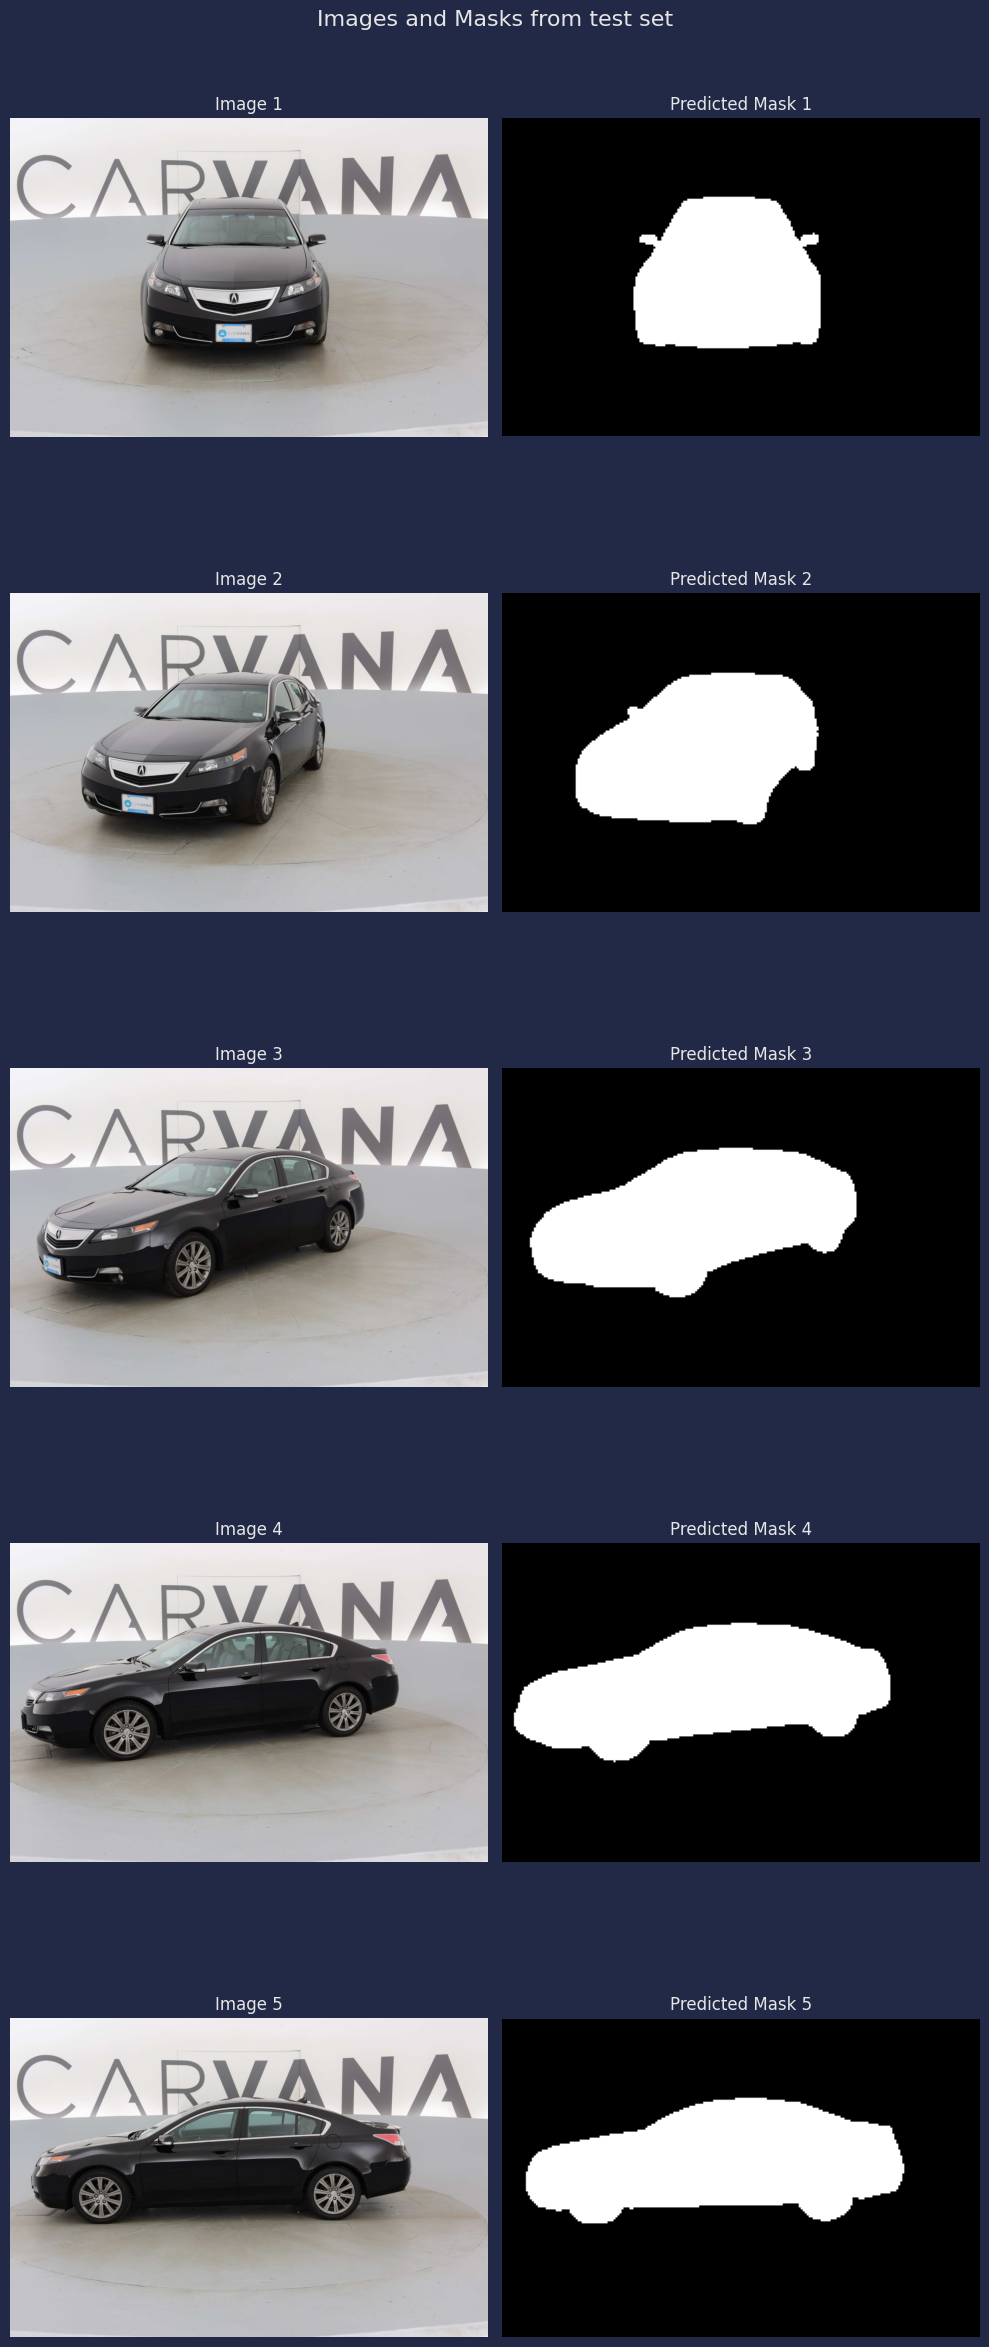

In [53]:
eval_test(unet_model, CONFIG['DEVICE'], CONFIG['DATASET_DIR'], 'test', val_test_transforms, 5)